# Loading data

In [3]:
import os
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from utils import load_folder, calculate_slope_with_dates

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Define the genus and phenology mappings
genus_mapping = {1: 'oak', 2: 'fir', 3: 'pine', 4: 'douglas', 5: 'chestnut', 6: 'spruce', 7: 'larch', 8: 'poplar', 9: 'ash', 10: 'beech', 11: 'alder', 12: 'birch', 13: 'hornbeam', 14: 'locusts'}
phen_mapping = {1: 'deciduous', 2: 'evergreen'}

def load_data_from_tile(path: str, config: str) -> dict:
    tile_id = os.path.basename(path).split('_')[1]
    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort()
    rgb = load_folder(os.path.join(path, 'rgb'))
    chm = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool)
    slope_map = calculate_slope_with_dates(rgb[:, 0], dates, len(rgb[:, 0]) / 2, len(rgb[:, 0])) / 100
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)

    path_features = os.path.join(path, 'features')
    r_APO = rasterio.open(os.path.join(path_features, f'APO_R_{config}.tif')).read()
    amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]
    crswir_APO = rasterio.open(os.path.join(path_features, f'APO_CRSWIR_{config}.tif')).read()
    amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]
    rcc_APO = rasterio.open(os.path.join(path_features, f'APO_RCC_{config}.tif')).read()
    amplitude_map_rcc, phase_map_rcc, offset_map_rcc = rcc_APO[0], rcc_APO[1], rcc_APO[2]
    dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
    elevation, aspect = dem[0], dem[1]

    features = {
        'amplitude_red': amplitude_map_r.ravel(),
        'phase_red': phase_map_r.ravel(),
        'offset_red': offset_map_r.ravel(),
        'amplitude_crswir': amplitude_map_crswir.ravel(),
        'phase_crswir': phase_map_crswir.ravel(),
        'offset_crswir': offset_map_crswir.ravel(),
        'amplitude_rcc': amplitude_map_rcc.ravel(),
        'phase_rcc': phase_map_rcc.ravel(),
        'offset_rcc': offset_map_rcc.ravel(),
        'elevation': elevation.ravel(),
        'aspect': aspect.ravel(),
        'tile_id': np.array([tile_id] * aspect.size)  # Add tile_id to the features
    }

    path_reference = os.path.join(path, 'reference_species')
    tif = [x for x in os.listdir(path_reference) if x.endswith('.tif')]
    reference = rasterio.open(os.path.join(path_reference, tif[0])).read()
    genus = reference[1]
    phen = reference[2]  # Assuming phenology data is stored in the third band
    valid_mask = (forest_mask & (phen != 0)).astype(bool)

    filtered_features = {k: v[valid_mask.ravel()] for k, v in features.items()}
    filtered_weights = weights[valid_mask.ravel()]
    filtered_genus = genus[valid_mask]
    filtered_phen = phen[valid_mask]

    filtered_features['genus'] = filtered_genus
    filtered_features['phen'] = filtered_phen

    df = pd.DataFrame(filtered_features)
    df = df.dropna()

    return df, filtered_weights[df.index]

def load_data(directory: str) -> pd.DataFrame:
    all_data = []
    all_weights = []
    tile_to_greco = {}

    for folder in tqdm(os.listdir(directory)):
        path = os.path.join(directory, folder)
        if folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
            continue
        try:
            tile_df, tile_weight = load_data_from_tile(path)
            tile_id = os.path.basename(path).split('_')[1]
            greco_region = "_".join(os.path.basename(path).split('_')[4:-1])
            tile_to_greco[tile_id] = greco_region
            tile_df['tile_id'] = tile_id
            all_data.append(tile_df)
            all_weights.append(tile_weight)
        except Exception as e:
            print(f"Error processing {folder}: {e}")
            continue

    print(f"Loaded {len(all_data)} tiles")
    data_df = pd.concat(all_data, ignore_index=True)
    weights_array = np.concatenate(all_weights)

    return data_df, weights_array, tile_to_greco

# Load data
data_dir = '/Users/arthurcalvi/Data/species/validation/tiles'
data, all_weights, tile_to_greco = load_data(data_dir)

# Verify data structure
print(data.head())
print(tile_to_greco)


 56%|█████▋    | 45/80 [00:31<00:16,  2.18it/s]

Error processing tile_51_20200102_20241230_Châtaigneraie_du_Centre_et_de_l'Ouest_training: /Users/arthurcalvi/Data/species/validation/tiles/tile_51_20200102_20241230_Châtaigneraie_du_Centre_et_de_l'Ouest_training/features/r_APO.tif: No such file or directory


 70%|███████   | 56/80 [00:39<00:14,  1.61it/s]

Error processing tile_61_20200102_20241230_Préalpes_du_Nord_validation: /Users/arthurcalvi/Data/species/validation/tiles/tile_61_20200102_20241230_Préalpes_du_Nord_validation/features/r_APO.tif: No such file or directory


100%|██████████| 80/80 [00:57<00:00,  1.40it/s]

Loaded 76 tiles
   amplitude_red  phase_red   offset_red  amplitude_crswir  phase_crswir  \
0     957.741079   2.319161  1500.688436        711.196831      2.470955   
1     916.679782   2.268373  1627.666845        603.858159      2.320875   
2     958.871271   2.306803  1275.661873        495.181812      2.596000   
3    1023.150974   2.302965  1293.520552        966.845420      0.073127   
4    1002.247977   2.310553  1367.740100        126.834061      0.650444   

   offset_crswir  amplitude_rcc  phase_rcc  offset_rcc  elevation      aspect  \
0   10124.470833       0.056940   2.785754    0.251651      500.0  144.143784   
1    9544.179084       0.022575   2.111464    0.274043      506.0  137.180191   
2   10854.815821       0.037488   2.192154    0.260588      500.0  147.326141   
3   10709.515334       0.061136   2.511686    0.240040      506.0  139.371399   
4   10245.407403       0.026446   2.397544    0.267068      506.0  132.160934   

  tile_id  genus  phen  
0      81      

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from collections import Counter
# Split data into training and validation sets
def stratified_group_split(data, test_size=0.25, random_state=42):
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    split = splitter.split(data, groups=data['tile_id'])
    train_idx, val_idx = next(split)
    
    train_data = data.iloc[train_idx]
    val_data = data.iloc[val_idx]
    
    return train_data, val_data

# Verify the split
def verify_split(train_data, val_data):
    # Check distribution of phenology classes
    train_phen_counts = Counter(train_data['phen'])
    val_phen_counts = Counter(val_data['phen'])
    
    print("Training phenology class distribution:", train_phen_counts)
    print("Validation phenology class distribution:", val_phen_counts)
    
    # Check distribution of GRECO regions
    train_greco_counts = Counter(train_data['greco_region'])
    val_greco_counts = Counter(val_data['greco_region'])
    
    print("Training GRECO region distribution:", train_greco_counts)
    print("Validation GRECO region distribution:", val_greco_counts)
    
    # Ensure no overlap of tiles between training and validation
    train_tiles = set(train_data['tile_id'])
    val_tiles = set(val_data['tile_id'])
    
    print("Common tiles between training and validation:", train_tiles.intersection(val_tiles))
    
    # Create summary table
    summary_table = pd.DataFrame(columns=['GRECO Region', 'Set', 'Deciduous', 'Evergreen', 'Total'])
    
    for greco_region in set(train_data['greco_region']).union(set(val_data['greco_region'])):
        train_deciduous = len(train_data[(train_data['greco_region'] == greco_region) & (train_data['phen'] == 1)])
        train_evergreen = len(train_data[(train_data['greco_region'] == greco_region) & (train_data['phen'] == 2)])
        val_deciduous = len(val_data[(val_data['greco_region'] == greco_region) & (val_data['phen'] == 1)])
        val_evergreen = len(val_data[(val_data['greco_region'] == greco_region) & (val_data['phen'] == 2)])
        
        summary_table = summary_table.append({
            'GRECO Region': greco_region,
            'Set': 'Training',
            'Deciduous': train_deciduous,
            'Evergreen': train_evergreen,
            'Total': train_deciduous + train_evergreen
        }, ignore_index=True)
        
        summary_table = summary_table.append({
            'GRECO Region': greco_region,
            'Set': 'Validation',
            'Deciduous': val_deciduous,
            'Evergreen': val_evergreen,
            'Total': val_deciduous + val_evergreen
        }, ignore_index=True)
    
    # Add total row
    total_deciduous_train = summary_table[summary_table['Set'] == 'Training']['Deciduous'].sum()
    total_evergreen_train = summary_table[summary_table['Set'] == 'Training']['Evergreen'].sum()
    total_deciduous_val = summary_table[summary_table['Set'] == 'Validation']['Deciduous'].sum()
    total_evergreen_val = summary_table[summary_table['Set'] == 'Validation']['Evergreen'].sum()
    
    summary_table = summary_table.append({
        'GRECO Region': 'Total',
        'Set': 'Training',
        'Deciduous': total_deciduous_train,
        'Evergreen': total_evergreen_train,
        'Total': total_deciduous_train + total_evergreen_train
    }, ignore_index=True)
    
    summary_table = summary_table.append({
        'GRECO Region': 'Total',
        'Set': 'Validation',
        'Deciduous': total_deciduous_val,
        'Evergreen': total_evergreen_val,
        'Total': total_deciduous_val + total_evergreen_val
    }, ignore_index=True)

    mapping_real_greco = {'Côtes_et_plateaux_de_la_Manche': 'Centre Nord semi-océanique',
                      'Côtes_et_plateaux_de_la_Manche': 'Centre Nord semi-océanique',
                      'Ardenne_primaire': 'Grand Est semi-continental',
                      'Préalpes_du_Nord': 'Alpes',
                      'Préalpes_du_Nord': 'Alpes',
                      'Garrigues' : 'Méditerranée',
                      'Massif_vosgien_central': 'Vosges',
                        'Premier_plateau_du_Jura': 'Jura',
                        'Piémont_pyrénéen' : 'Pyrénées',
                        'Terres_rouges': 'Sud-Ouest océanique' ,
                          'Corse_occidentale': 'Corse',
                        "Châtaigneraie_du_Centre_et_de_l'Ouest": 'Massif central' ,
                        'Ouest-Bretagne_et_Nord-Cotentin': 'Grand Ouest cristallin et océanique', 
                        'Total': 'Total'

}

    summary_table['GRECO Region'] = summary_table['GRECO Region'].map(mapping_real_greco)
    
    print(summary_table)
    
    return summary_table

configs = ["resampled_no_weights",
            "no_resample_no_weights", 
            "no_resample_cloud_weights",
            "no_resample_cloud_disturbance_weights"]

# Assuming data, all_weights, and tile_to_greco are already loaded from the provided code
for config in tqdm(configs): 
    data, all_weights, tile_to_greco = load_data(data_dir)
    # Add GRECO region to the data
    data['greco_region'] = data['tile_id'].map(tile_to_greco)



    train_data, val_data = stratified_group_split(data)



    # Verify the split
    summary_table = verify_split(train_data, val_data)
    summary_table.to_csv('summary_table_{config}.csv', index=False)
    # Save the datasets
    train_data.to_csv(f'train_data_{config}.csv', index=False)
    val_data.to_csv(f'val_data_{config}.csv', index=False)

    print("Training and validation datasets saved.")


Training phenology class distribution: Counter({1: 541406, 2: 468264})
Validation phenology class distribution: Counter({1: 173805, 2: 142589})
Training GRECO region distribution: Counter({'Garrigues': 340289, 'Terres_rouges': 245487, "Châtaigneraie_du_Centre_et_de_l'Ouest": 151018, 'Corse_occidentale': 77804, 'Préalpes_du_Nord': 45811, 'Préalpes_du_Nord': 45600, 'Côtes_et_plateaux_de_la_Manche': 42448, 'Ardenne_primaire': 41812, 'Premier_plateau_du_Jura': 10528, 'Côtes_et_plateaux_de_la_Manche': 6354, 'Massif_vosgien_central': 1683, 'Piémont_pyrénéen': 421, 'Ouest-Bretagne_et_Nord-Cotentin': 415})
Validation GRECO region distribution: Counter({'Terres_rouges': 136873, 'Garrigues': 50484, 'Préalpes_du_Nord': 32524, 'Corse_occidentale': 27026, "Châtaigneraie_du_Centre_et_de_l'Ouest": 26045, 'Côtes_et_plateaux_de_la_Manche': 22701, 'Ardenne_primaire': 18385, 'Premier_plateau_du_Jura': 1641, 'Ouest-Bretagne_et_Nord-Cotentin': 360, 'Piémont_pyrénéen': 196, 'Massif_vosgien_central': 159})

# Thresholding 

# Random Forest

1    358524
2    306795
Name: phen, dtype: int64
1    358941
2    306379
Name: phen, dtype: int64


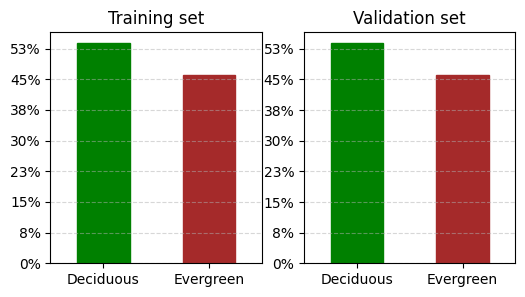

In [13]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_valid, y_phen_valid, test_size=0.5, random_state=42)

# Look at distribution of phenological stages (1 = deciduous, 2 = evergreen) in training and validation sets 
# PLOT DISTRIBUTION OF PHENOLOGICAL STAGES IN TRAINING AND VALIDATION SETS AS A BAR PLOT
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
y_train.value_counts().plot(kind='bar', ax=ax[0], title='Training set')
y_test.value_counts().plot(kind='bar', ax=ax[1], title='Validation set')
#SET TICK LABELS
ax[0].set_xticklabels(['Deciduous', 'Evergreen'])
ax[1].set_xticklabels(['Deciduous', 'Evergreen'])
#put tick label on the bar 
ax[0].tick_params(axis='x', rotation=0)
ax[1].tick_params(axis='x', rotation=0)

#set as percentage 
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x/len(y_train))))
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x/len(y_test))))
#set color evergreen as green and deciduous as brown
ax[0].get_children()[0].set_color('brown')
ax[0].get_children()[1].set_color('green')
ax[1].get_children()[0].set_color('brown')
ax[1].get_children()[1].set_color('green')

#add horizontal grid lines
ax[0].yaxis.grid(True, linestyle='--', alpha=0.5)
ax[1].yaxis.grid(True, linestyle='--', alpha=0.5)

#print in term of counts
print(y_train.value_counts())
print(y_test.value_counts())


# Random Forest Classifier 

Accuracy: 0.9801358744664221
              precision    recall  f1-score   support

           1       0.98      0.98      0.98    358941
           2       0.98      0.98      0.98    306379

    accuracy                           0.98    665320
   macro avg       0.98      0.98      0.98    665320
weighted avg       0.98      0.98      0.98    665320



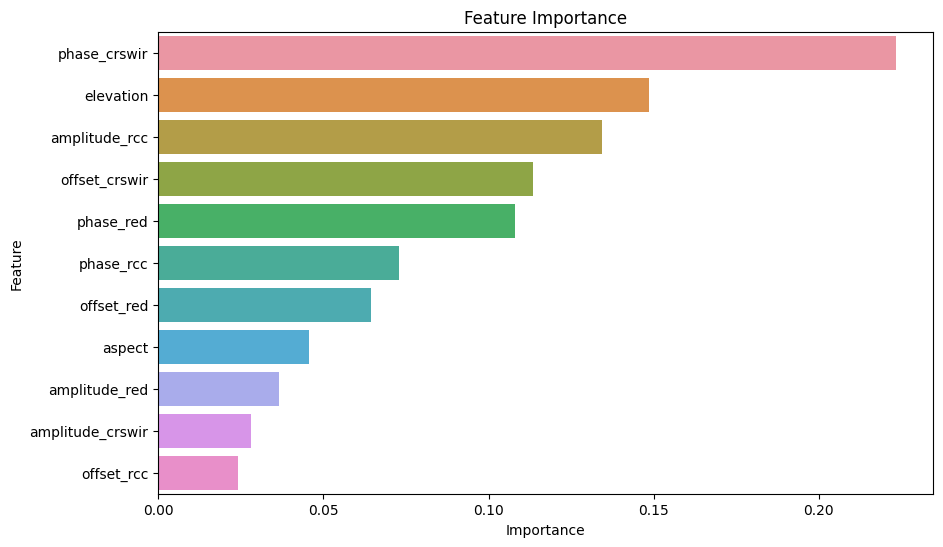

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

Spatial validation ensures that your model generalizes well across different forest habitats. It involves training and testing the model on different spatial units. Here, we'll use a leave-one-out approach for different tiles:

# Threshold

In [1]:
import os
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import load_folder, calculate_slope_with_dates
from sklearn.impute import SimpleImputer

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Define the genus mapping
genus_mapping = {
    1: 'oak', 2: 'fir', 3: 'pine', 4: 'douglas', 5: 'chestnut',
    6: 'spruce', 7: 'larch', 8: 'poplar', 9: 'ash', 10: 'beech',
    11: 'alder', 12: 'birch', 13: 'hornbeam', 14: 'locusts'
}

phen_mapping = {1: 'deciduous', 2: 'evergreen'}

# Load the data and preprocess it
def load_data_from_tile(path: str) -> dict:
    dates = [datetime.strptime(filename.split('_')[0], '%Y-%m-%d') for filename in os.listdir(os.path.join(path, 'rgb'))]
    dates.sort()
    rgb = load_folder(os.path.join(path, 'rgb'))
    chm = rasterio.open(os.path.join(path, 'tree_map', 'CHM2020.tif')).read(1)
    forest_mask = (chm > 250).astype(bool)
    slope_map = calculate_slope_with_dates(rgb[:, 0], dates, len(rgb[:, 0]) / 2, len(rgb[:, 0])) / 100
    weights = (1 - abs(slope_map.ravel())).clip(0, 1)

    path_features = os.path.join(path, 'features')
    r_APO = rasterio.open(os.path.join(path_features, 'r_APO.tif')).read()
    amplitude_map_r, phase_map_r, offset_map_r = r_APO[0], r_APO[1], r_APO[2]
    crswir_APO = rasterio.open(os.path.join(path_features, 'crswir_APO.tif')).read()
    amplitude_map_crswir, phase_map_crswir, offset_map_crswir = crswir_APO[0], crswir_APO[1], crswir_APO[2]
    rcc_APO = rasterio.open(os.path.join(path_features, 'rcc_APO.tif')).read()
    amplitude_map_rcc, phase_map_rcc, offset_map_rcc = rcc_APO[0], rcc_APO[1], rcc_APO[2]
    dem = rasterio.open(os.path.join(path_features, 'elevation_aspect.tif')).read()
    elevation, aspect = dem[0], dem[1]

    features = {
        'amplitude_red': amplitude_map_r.ravel(),
        'phase_red': phase_map_r.ravel(),
        'offset_red': offset_map_r.ravel(),
        'amplitude_crswir': amplitude_map_crswir.ravel(),
        'phase_crswir': phase_map_crswir.ravel(),
        'offset_crswir': offset_map_crswir.ravel(),
        'amplitude_rcc': amplitude_map_rcc.ravel(),
        'phase_rcc': phase_map_rcc.ravel(),
        'offset_rcc': offset_map_rcc.ravel(),
        'elevation': elevation.ravel(),
        'aspect': aspect.ravel()
    }

    filtered_features = {k: v[forest_mask.ravel()] for k, v in features.items()}
    filtered_weights = weights[forest_mask.ravel()]

    path_reference = os.path.join(path, 'reference_species')
    tif = [x for x in os.listdir(path_reference) if x.endswith('.tif')]
    reference = rasterio.open(os.path.join(path_reference, tif[0])).read()
    genus = reference[1]
    phen = reference[2]  # Assuming phenology data is stored in the third band
    filtered_genus = genus[forest_mask]
    filtered_phen = phen[forest_mask]

    filtered_features['genus'] = filtered_genus
    filtered_features['phen'] = filtered_phen

    return filtered_features, filtered_weights

def load_data(directory: str) -> pd.DataFrame:
    all_data = []
    all_weights = []

    for folder in tqdm(os.listdir(directory)):
        path = os.path.join(directory, folder)
        if folder.endswith('validation') or folder.__contains__('.DS_Store') or folder.__contains__('.txt'):
            continue
        try:
            tile_data, tile_weight = load_data_from_tile(path)
            all_data.append(pd.DataFrame(tile_data))
            all_weights.append(tile_weight)
        except Exception as e:
            print(f"Error processing {folder}: {e}")
            continue

    return pd.concat(all_data, ignore_index=True), np.concatenate(all_weights)

# Load data
data_dir = '/Users/arthurcalvi/Data/species/validation/tiles'
data, all_weights = load_data(data_dir)

# Preprocess data
features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']
X = data[features]
y_phen = data['phen']

# Replace infinite values with NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle NaNs by imputing with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Update X with imputed values
X = pd.DataFrame(X_imputed, columns=X.columns)

# Filter out null data in y_phen
valid_mask = y_phen != 0
X_valid = X[valid_mask]
y_phen_valid = y_phen[valid_mask]

# Identify the best feature using ROC-AUC score
best_feature = None
best_roc_auc = 0
roc_auc_list = []

for feature in features:
    roc_auc = roc_auc_score(y_phen_valid, X_valid[feature])
    roc_auc_list.append(roc_auc)
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_feature = feature

print(f"Best feature for distinguishing deciduous and evergreen trees: {best_feature} with ROC-AUC score: {best_roc_auc}")

# Compute the optimal threshold for the best feature
fpr, tpr, thresholds = roc_curve(y_phen_valid, X_valid[best_feature], pos_label=2)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold for {best_feature}: {optimal_threshold}")


 55%|█████▌    | 44/80 [00:18<00:11,  3.20it/s]

Error processing tile_51_20200102_20241230_Châtaigneraie_du_Centre_et_de_l'Ouest_training: /Users/arthurcalvi/Data/species/validation/tiles/tile_51_20200102_20241230_Châtaigneraie_du_Centre_et_de_l'Ouest_training/features/r_APO.tif: No such file or directory


100%|██████████| 80/80 [00:33<00:00,  2.40it/s]


Best feature for distinguishing deciduous and evergreen trees: phase_red with ROC-AUC score: 0.8588427198896135
Optimal threshold for phase_red: 1.416806239106071


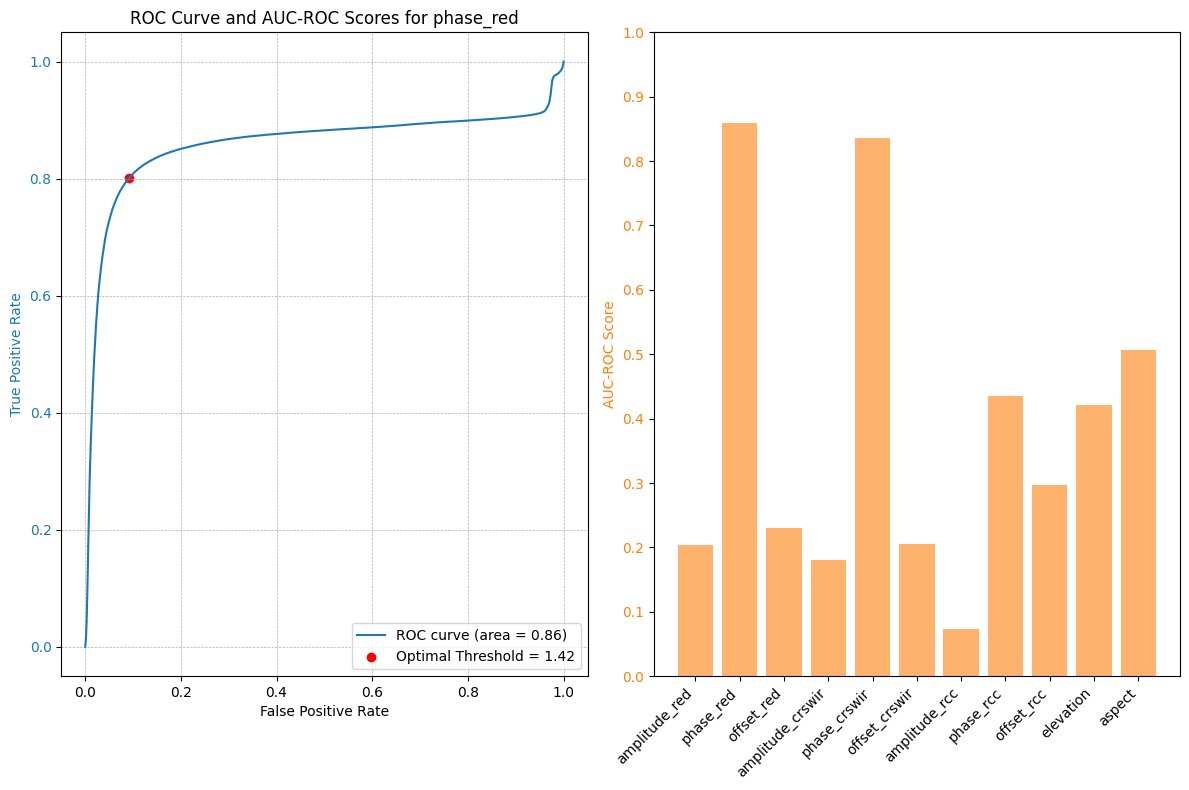

In [2]:
import matplotlib.pyplot as plt

# Collecting ROC-AUC scores for all features
roc_auc_list = []

for feature in features:
    roc_auc = roc_auc_score(y_phen_valid, X_valid[feature])
    roc_auc_list.append(roc_auc)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plotting the ROC curve
color = 'tab:blue'
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate', color=color)
ax1.plot(fpr, tpr, color=color, label=f'ROC curve (area = {best_roc_auc:.2f})')
ax1.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='lower right')
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.set_title(f'ROC Curve and AUC-ROC Scores for {best_feature}')

# Adding a second y-axis for the histogram
color = 'tab:orange'
ax2.set_ylabel('AUC-ROC Score', color=color)
ax2.bar(features, roc_auc_list, color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_xticklabels(features, rotation=45, ha='right')

fig.tight_layout()  
plt.show()

import os 
os.makedirs('images', exist_ok=True)
fig.savefig('images/roc_auc_scores_and_features.png', dpi=300)


In [3]:
y_phen_valid[ y_phen_valid == 2].sum()

810720

In [4]:
y_phen_valid[ y_phen_valid == 1].sum()

287278

# RF